Search for granules on the cloud for a box of interest, run custom candidate fire pixel extraction, map I4 + custom candidates. Searching for VIIRS L2 fire data (swaths and text files) in the cloud and checking which versions are available

In [22]:
#conda activate /projects/myenvs/candidates-env
import xarray as xr
import earthaccess
from earthaccess import Auth, Store, DataCollections, DataGranules
import datetime as dt
import time
import os
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import folium
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import rioxarray
from scipy.spatial.distance import cdist

In [23]:
#read in pyroCB catalog
file = f'/projects/shared-buckets/qulizad/NRL_pyroCb_inventory_2023_v1.csv'
df = pd.read_csv(file, header=0, usecols=["datetime", "fire_name", "region", "lat", "lon"])
rslt_df = df.loc[(df['region'] == 'Canada')]  #.reset_index(drop=True) #subsetting to Canada
#rslt_df.loc[5] ## only prints up to not including 10th record

In [24]:
#loop through all pyroCBs, run methods to make output directories, fetch data, and generate candidate fires

#%time
# %time is not the same as %%time because the former only see's how long the current 
#line takes to execute, whereas the latter checks the how the current line and 
#following lines take to execute
#[:] is the array slice syntax for every element in the array


for i in rslt_df.index[14:15]:
    fire_name = rslt_df.loc[i, 'fire_name']
    lat = rslt_df.loc[i, 'lat']
    lon = rslt_df.loc[i, 'lon']
    dat = rslt_df.loc[i, 'datetime']
    date_object = dt.datetime.strptime(dat, "%m/%d/%y %H:%M")    
    print(i, fire_name, date_object)
    
    
#     satellites = ['SNPP','NOAA20']
#     for s in satellites:
#         #s3_links, files = fetch_data(s)
        
#         if s=='SNPP': products = ['VNP03IMG','VNP02IMG','VNP14IMG']
#         elif s=='NOAA20': products = ['VJ103IMG','VJ102IMG','VJ114IMG']
        
#         run_fire_algorithm() #using level 1 data

#         #run_custom_fire_algorithm(s3_links, files) #using level 1 data
#         #run_viirs_l2_fire_algoithm(s3_links, files) #using level 2 data
        



16 2023-G80287 2023-05-20 22:50:00


In [25]:
start_date = date_object + dt.timedelta(-1)
end_date = date_object + dt.timedelta(+1)
    
start_date = start_date.strftime("%Y-%m-%d")
end_date = end_date.strftime("%Y-%m-%d")

In [26]:
EXTENT = [lon - 0.5, lat - 0.5, lon + 0.5, lat + 0.5]
START = start_date
END = end_date

In [27]:
satellites = ['SNPP','NOAA20']
for s in satellites:
    #s3_links, files = fetch_data(s)
        
    if s=='SNPP': products = ['VNP03IMG','VNP02IMG','VNP14IMG']
    elif s=='NOAA20': products = ['VJ103IMG','VJ102IMG','VJ114IMG']
        
    #run_fire_algorithm() #using level 1 data

    #run_custom_fire_algorithm(s3_links, files) #using level 1 data
    #run_viirs_l2_fire_algoithm(s3_links, files) #using level 2 data

In [28]:
output_dir = '/projects/shared-buckets/qulizad/scripts/outputs/canada/'

In [29]:
#first get the L1 geolocation and science data via direct S3 access
#may require restarting the kernel if permission errors

files = {}

#geolocation 03IMG
results = earthaccess.search_data(
    short_name=products[0],
    bounding_box=(EXTENT[0],EXTENT[1],EXTENT[2],EXTENT[3]),
    temporal=(START, END),
    count=100
)
files[products[0]] = earthaccess.open(results)

#science data 02IMG
results = earthaccess.search_data(
    short_name=products[1],
    bounding_box=(EXTENT[0],EXTENT[1],EXTENT[2],EXTENT[3]),
    temporal=(START, END),
    count=100
)
files[products[1]] = earthaccess.open(results)

files

Granules found: 11
Opening 11 granules, approx size: 1.8 GB
using provider: LAADS


QUEUEING TASKS | : 11it [00:00, 1334.37it/s]
PROCESSING TASKS | : 100%|██████████| 11/11 [00:00<00:00, 162.60it/s]
COLLECTING RESULTS | : 100%|██████████| 11/11 [00:00<00:00, 176771.43it/s]


Granules found: 11
Opening 11 granules, approx size: 2.21 GB
using provider: LAADS


QUEUEING TASKS | : 11it [00:00, 2019.76it/s]
PROCESSING TASKS | : 100%|██████████| 11/11 [00:00<00:00, 487.16it/s]
COLLECTING RESULTS | : 100%|██████████| 11/11 [00:00<00:00, 173448.66it/s]


{'VJ103IMG': [<File-like object S3FileSystem, prod-lads/VJ103IMG/VJ103IMG.A2023139.0918.021.2023139135435.nc>,
  <File-like object S3FileSystem, prod-lads/VJ103IMG/VJ103IMG.A2023139.1100.021.2023139161810.nc>,
  <File-like object S3FileSystem, prod-lads/VJ103IMG/VJ103IMG.A2023139.1906.021.2023140002842.nc>,
  <File-like object S3FileSystem, prod-lads/VJ103IMG/VJ103IMG.A2023139.1912.021.2023140003548.nc>,
  <File-like object S3FileSystem, prod-lads/VJ103IMG/VJ103IMG.A2023139.2048.021.2023140025138.nc>,
  <File-like object S3FileSystem, prod-lads/VJ103IMG/VJ103IMG.A2023140.0900.021.2023140143442.nc>,
  <File-like object S3FileSystem, prod-lads/VJ103IMG/VJ103IMG.A2023140.1036.021.2023140161440.nc>,
  <File-like object S3FileSystem, prod-lads/VJ103IMG/VJ103IMG.A2023140.1218.021.2023140184540.nc>,
  <File-like object S3FileSystem, prod-lads/VJ103IMG/VJ103IMG.A2023140.1848.021.2023141003537.nc>,
  <File-like object S3FileSystem, prod-lads/VJ103IMG/VJ103IMG.A2023140.2030.021.2023141023408.nc>

In [30]:
#initiate cloud session - need to reauthenticate every hour :(

auth = Auth() 
#auth.login(strategy="interactive", persist=True) #RUN THIS THE FIRST TIME
auth.login(strategy="netrc") #read credentials from previously saved ~/.netrc file

store = Store(auth)
fs = store.get_s3fs_session('LAADS') #daac or provider name

In [31]:
product = products[2]

Query = DataGranules().short_name(product).bounding_box(EXTENT[0],EXTENT[1],EXTENT[2],EXTENT[3]).temporal(START,END)

print(Query.hits(), 'hits')
cloud_granules = Query.get(800) #first 800 results
print('cloud hosted', cloud_granules[0].cloud_hosted)

s3_links = {}
s3_links[product] = []
for granule in cloud_granules:
    s3_links[product].extend(granule.data_links(access="in-region"))
s3_links[product] = sorted(s3_links[product]) 
files[product] = store.open(s3_links[product], provider="LAADS")

print(product)
pprint(files)

10 hits
cloud hosted True


QUEUEING TASKS | : 10it [00:00, 2054.42it/s]
PROCESSING TASKS | : 100%|██████████| 10/10 [00:01<00:00,  8.95it/s]
COLLECTING RESULTS | : 100%|██████████| 10/10 [00:00<00:00, 127100.12it/s]

VJ114IMG
{'VJ102IMG': [<File-like object S3FileSystem, prod-lads/VJ102IMG/VJ102IMG.A2023139.0918.021.2023139141715.nc>,
              <File-like object S3FileSystem, prod-lads/VJ102IMG/VJ102IMG.A2023139.1100.021.2023139164140.nc>,
              <File-like object S3FileSystem, prod-lads/VJ102IMG/VJ102IMG.A2023139.1906.021.2023140005104.nc>,
              <File-like object S3FileSystem, prod-lads/VJ102IMG/VJ102IMG.A2023139.1912.021.2023140010410.nc>,
              <File-like object S3FileSystem, prod-lads/VJ102IMG/VJ102IMG.A2023139.2048.021.2023140032109.nc>,
              <File-like object S3FileSystem, prod-lads/VJ102IMG/VJ102IMG.A2023140.0900.021.2023140150238.nc>,
              <File-like object S3FileSystem, prod-lads/VJ102IMG/VJ102IMG.A2023140.1036.021.2023140163939.nc>,
              <File-like object S3FileSystem, prod-lads/VJ102IMG/VJ102IMG.A2023140.1218.021.2023140190723.nc>,
              <File-like object S3FileSystem, prod-lads/VJ102IMG/VJ102IMG.A2023140.1848.021.20231410101

In [32]:
#test open one 03IMG geolocation (optional)
xr.open_dataset(files[products[0]][0], engine='h5netcdf', group='geolocation_data')

<xarray.Dataset>
Dimensions:          (number_of_lines: 6464, number_of_pixels: 6400)
Dimensions without coordinates: number_of_lines, number_of_pixels
Data variables:
    latitude         (number_of_lines, number_of_pixels) float32 ...
    longitude        (number_of_lines, number_of_pixels) float32 ...
    height           (number_of_lines, number_of_pixels) float32 ...
    range            (number_of_lines, number_of_pixels) float32 ...
    sensor_azimuth   (number_of_lines, number_of_pixels) float32 ...
    sensor_zenith    (number_of_lines, number_of_pixels) float32 ...
    solar_azimuth    (number_of_lines, number_of_pixels) float32 ...
    solar_zenith     (number_of_lines, number_of_pixels) float32 ...
    land_water_mask  (number_of_lines, number_of_pixels) float32 ...
    quality_flag     (number_of_lines, number_of_pixels) uint8 ...

In [33]:
files[products[0]][0].path

'prod-lads/VJ103IMG/VJ103IMG.A2023139.0918.021.2023139135435.nc'

In [34]:
files[products[2]][1]

<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/VJ114IMG.002/VJ114IMG.A2023139.1100.002.2024099203457/VJ114IMG.A2023139.1100.002.2024099203457.nc>

In [35]:
files[products[2]][1].path

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/VJ114IMG.002/VJ114IMG.A2023139.1100.002.2024099203457/VJ114IMG.A2023139.1100.002.2024099203457.nc'

In [37]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap

mask_colors = [mpl.colormaps['tab10'](c) for c in [4,6,5,0,9,2,7,8,1,3]] #fire mask colors
dets_colors = ['white']*7 + ['black']*3                                  #black and white version

cmp1 = ListedColormap(mask_colors)
cmp2 = ListedColormap(dets_colors)

['A2023139', '0918']
['A2023139', '1100']
['A2023139', '1906']
['A2023139', '1912']
['A2023139', '2048']
['A2023140', '0900']
['A2023140', '1036']
['A2023140', '1218']
['A2023140', '1848']
['A2023140', '2030']
['A2023140', '2212']
error with file ['A2023140', '2212']
done


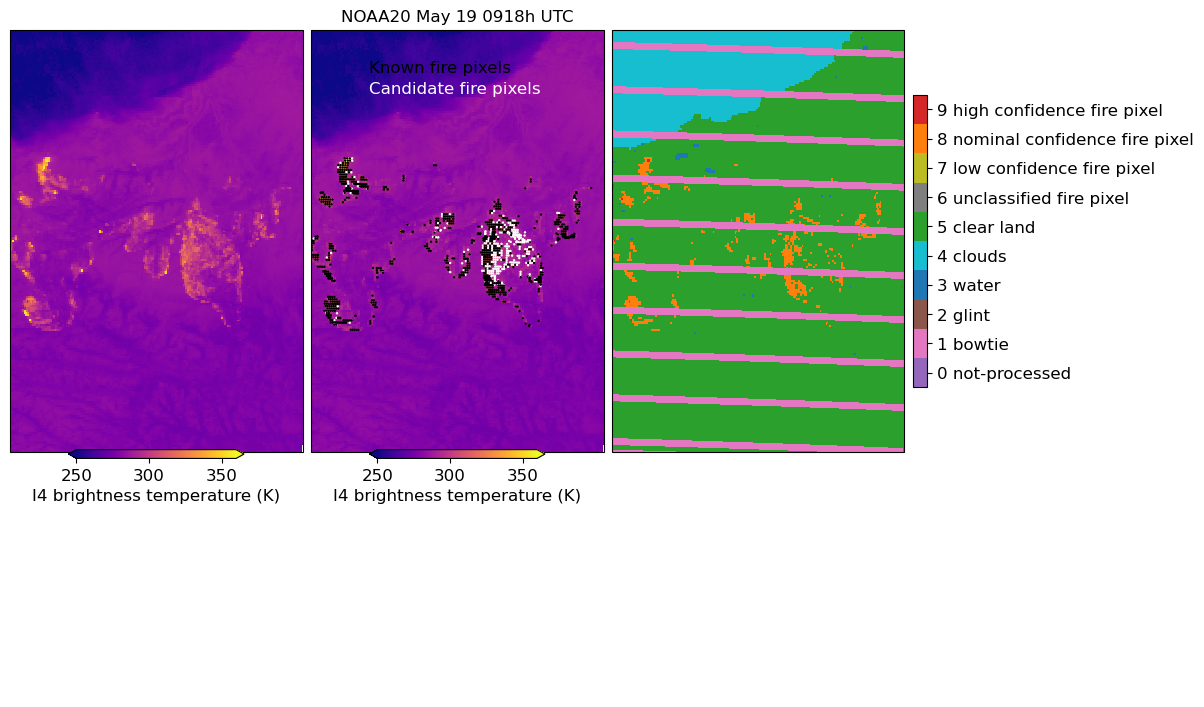

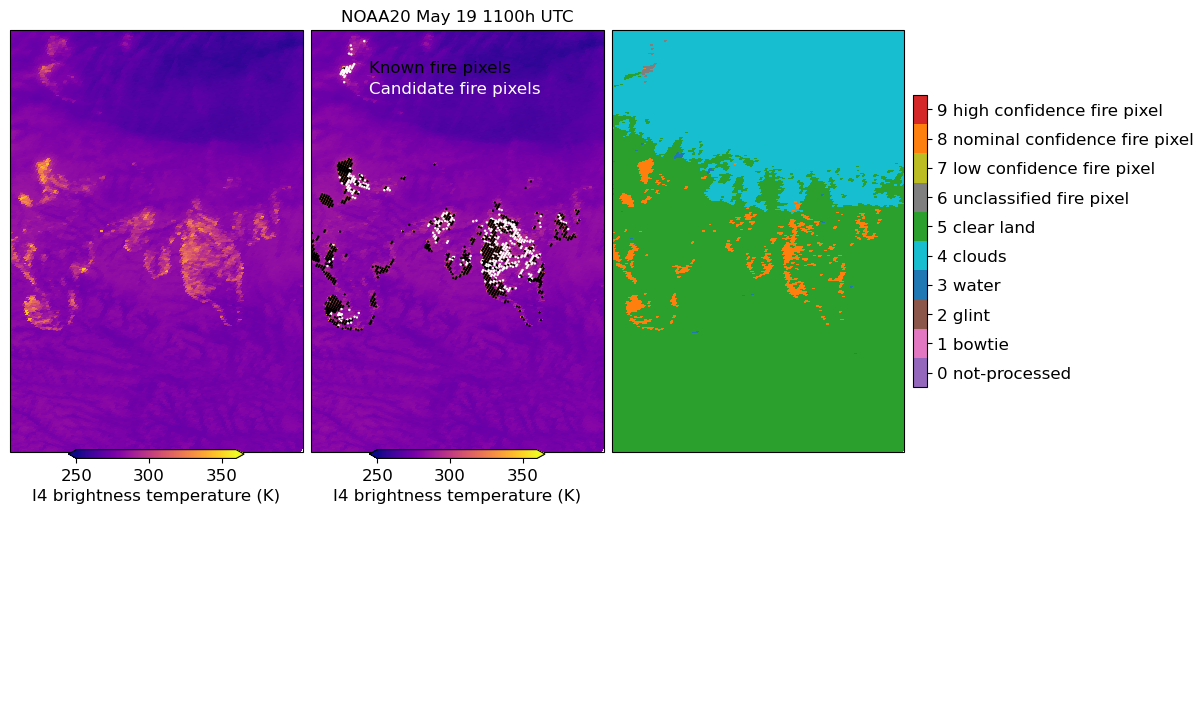

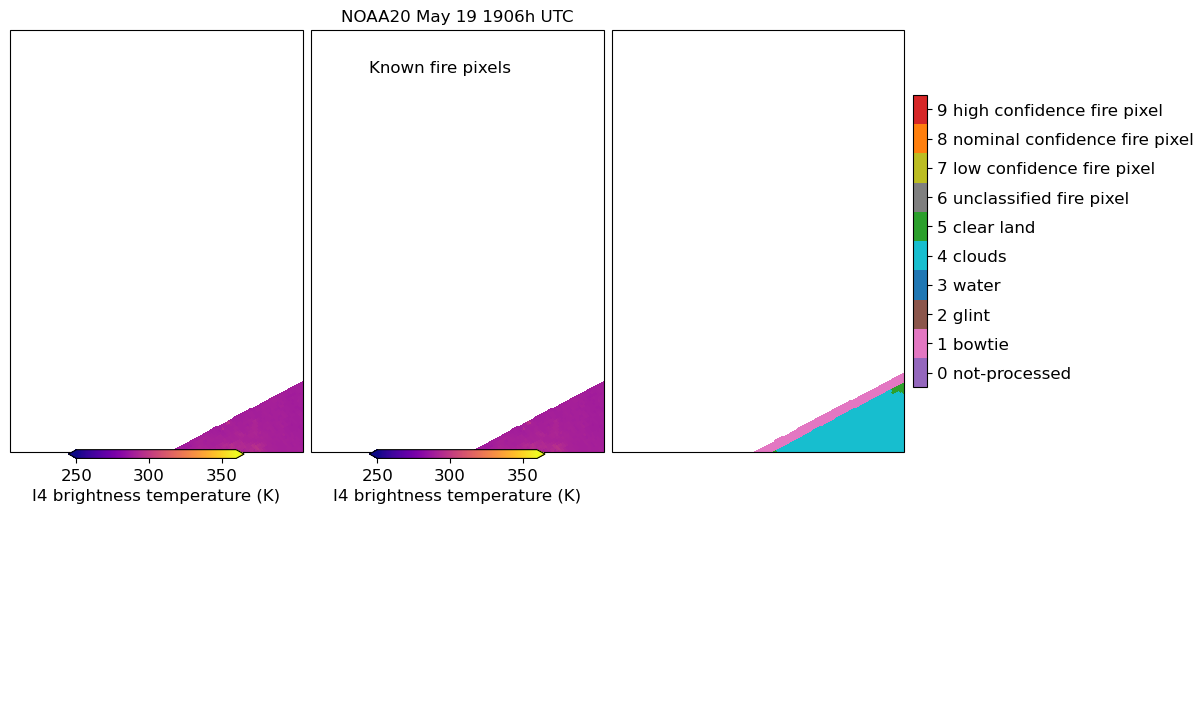

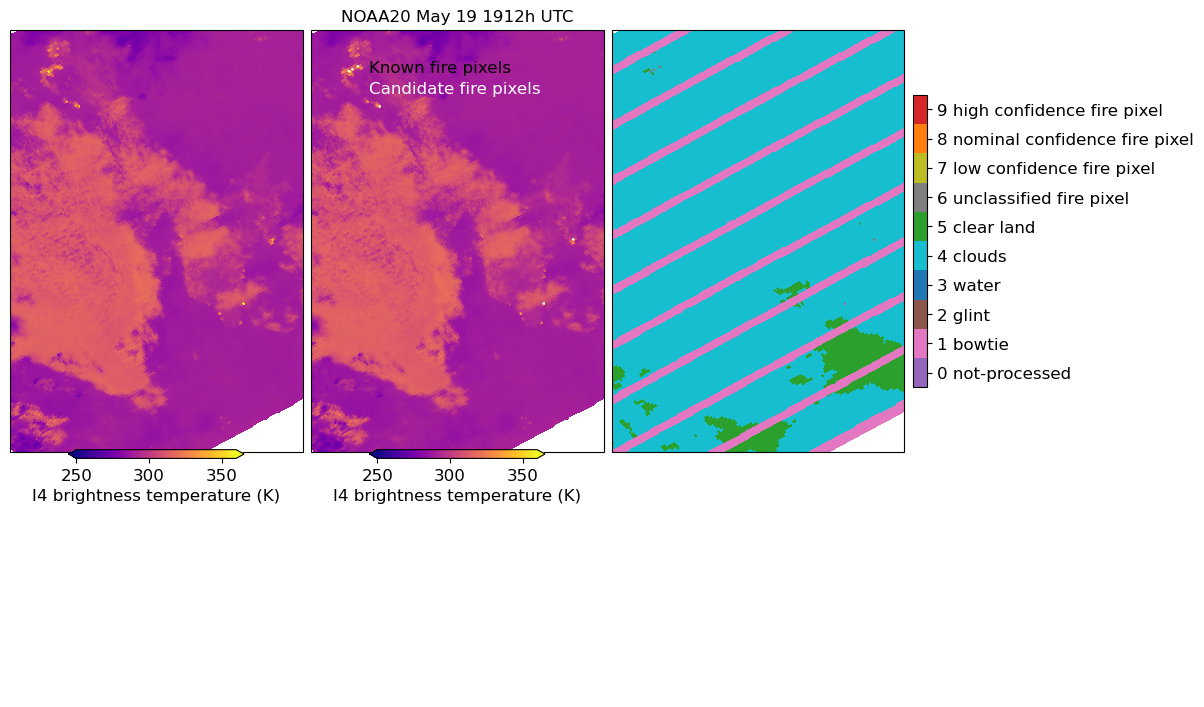

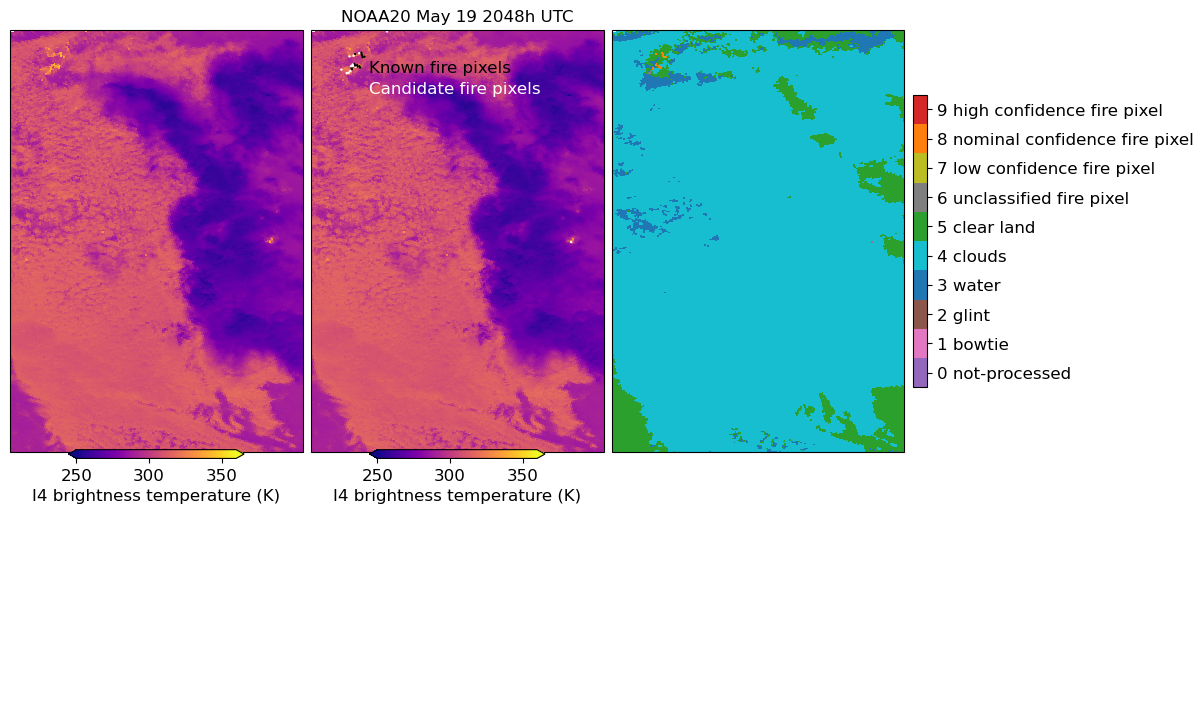

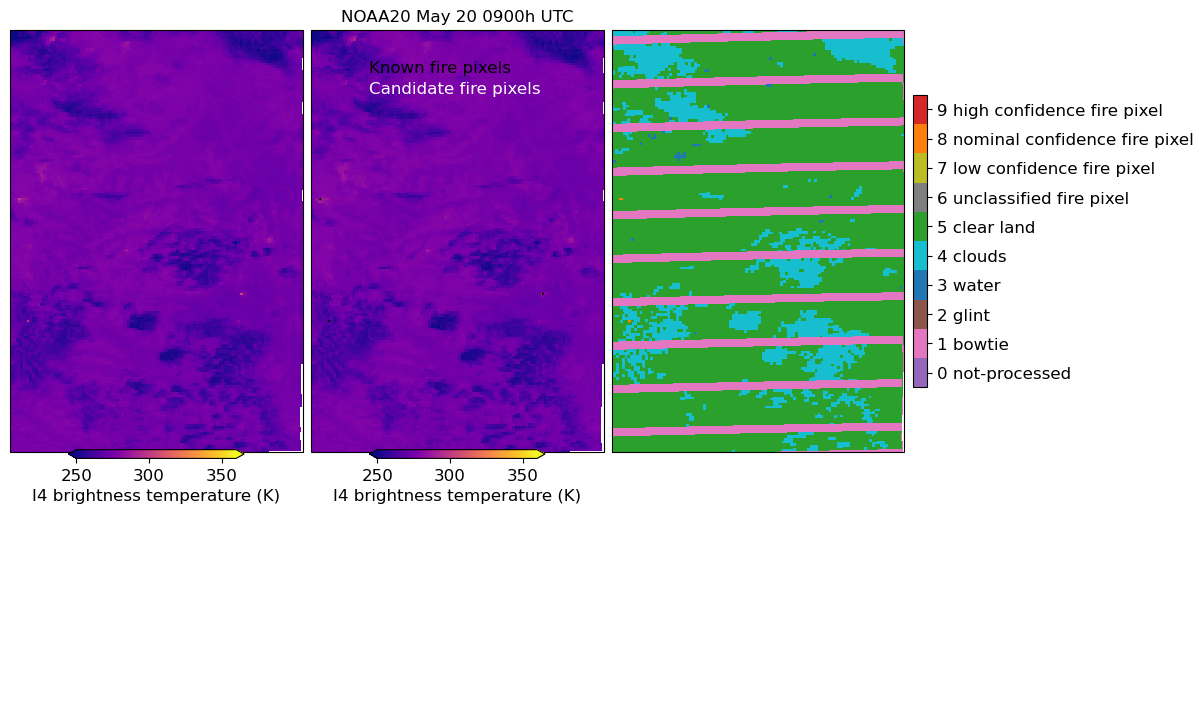

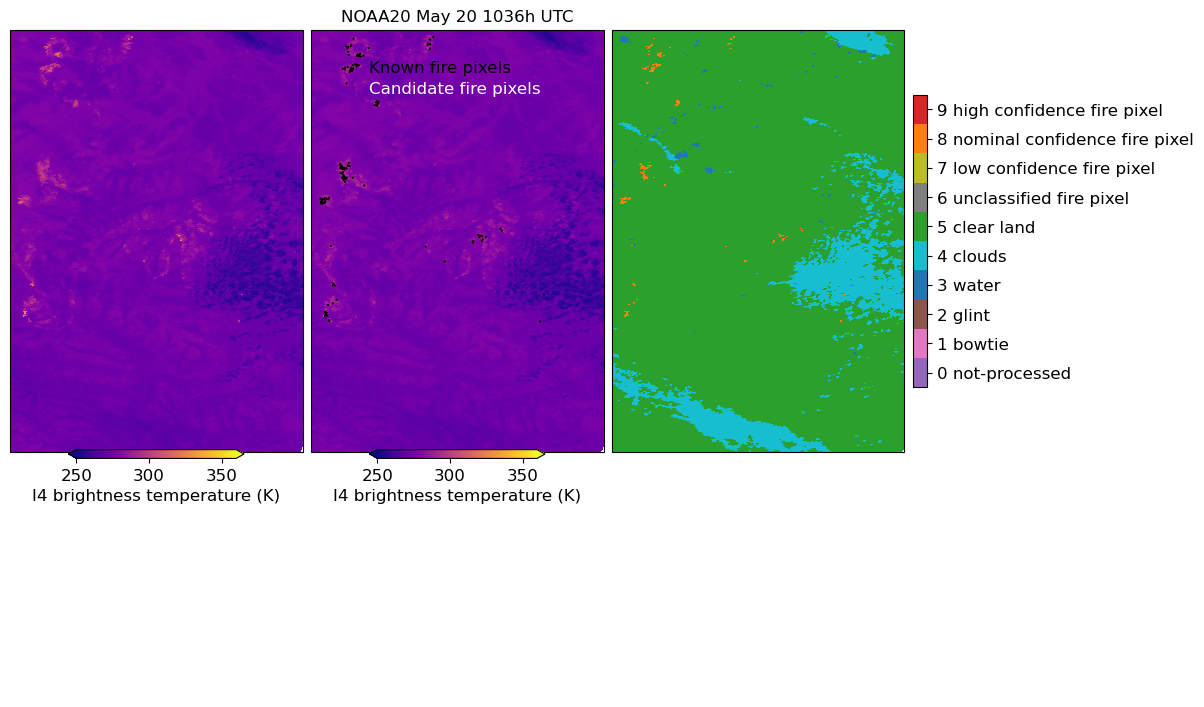

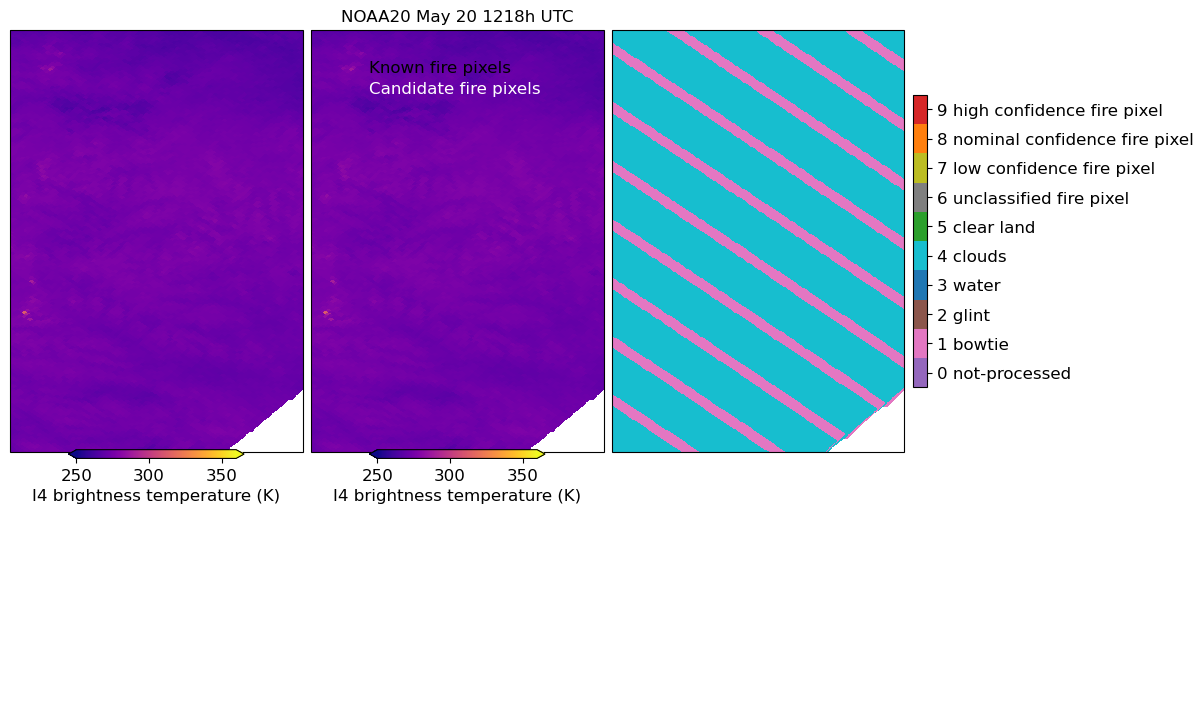

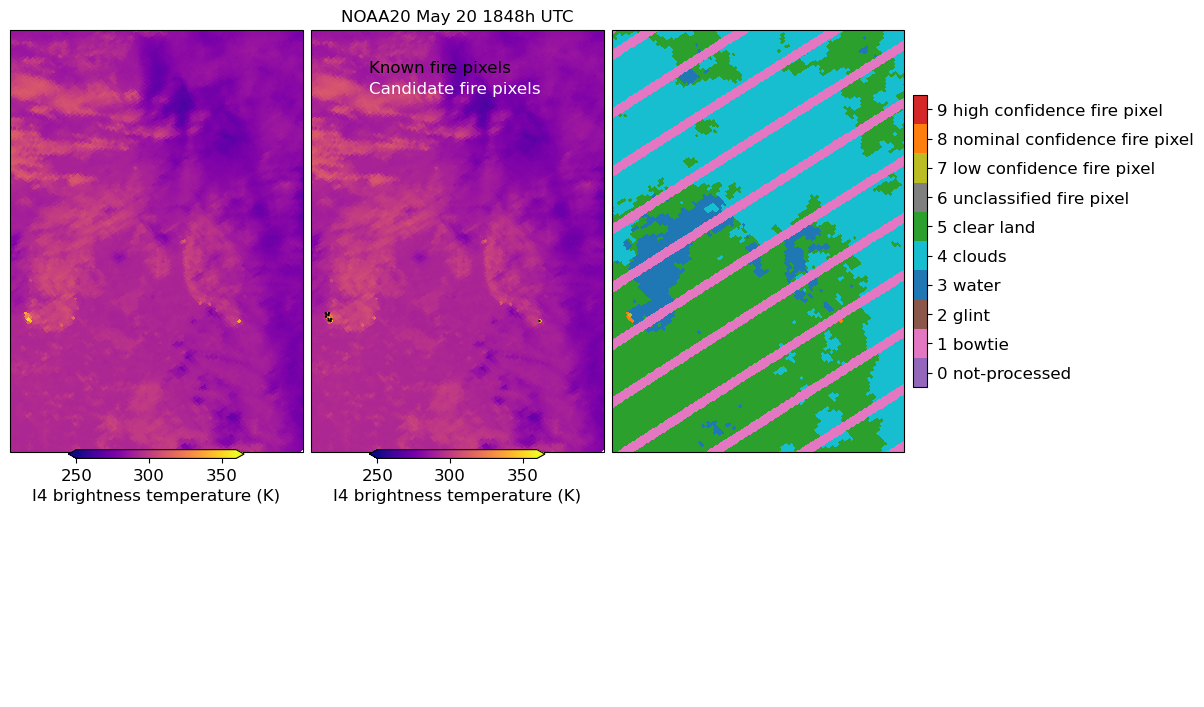

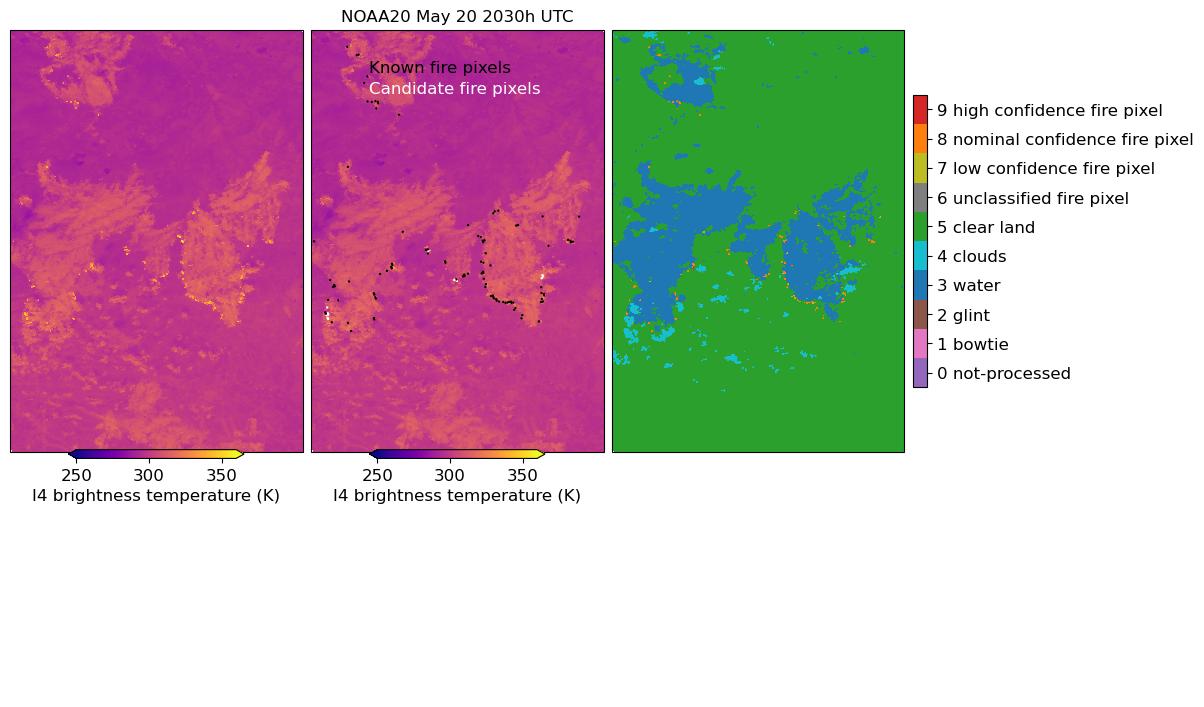

In [38]:
all_dets = pd.DataFrame()

for i in range(len(files[products[0]])): #VNP03IMG or VJ103IMG
    timestamp = files[products[0]][i].path.split('.')[-5:-3]
    print(timestamp)
    year = timestamp[0][1:5]
    day = timestamp[0][5:8]
    time = timestamp[1]
    date = dt.datetime.strptime(year+day, '%Y%j').strftime('%b %d') 
    acq_datetime = dt.datetime.strptime(year+day+time[:2]+time[2:], '%Y%j%H%M').strftime('%Y-%m-%d %H:%M:00 +00:00') 
    daytime = int(time) > 1500 #depends on timezone

    try:
        #open 03IMG geolocation
        geo = xr.open_dataset(files[products[0]][i], engine='h5netcdf', group='geolocation_data')
        lon = geo['longitude'][:]
        lat = geo['latitude'][:]
        _, j = np.indices(geo.longitude.shape) #line and sample
        
        scene = (lon > EXTENT[0]) & (lon < EXTENT[2]) & (lat > EXTENT[1]) & (lat < EXTENT[3])

        #crop down the datasets for memory 
        indices = np.where(scene)
        x0 = indices[0].min()
        x1 = indices[0].max()
        y0 = indices[1].min()
        y1 = indices[1].max()

        lon = lon[x0:x1, y0:y1]
        lat = lat[x0:x1, y0:y1]
        j = j[x0:x1, y0:y1]
        
        #open 02IMG science data, i4 band
        data = xr.open_dataset(files[products[1]][i], engine='h5netcdf', group='observation_data')
        data = data.sel(number_of_lines=slice(x0,x1), number_of_pixels=slice(y0,y1))
        
        i4 = data['I04'] #xarray already encodes the scale factor and offset
        scale = data.I04.encoding['scale_factor']
        offset = data.I04.encoding['add_offset']
        i4 = (i4[:,:] - offset) / scale #return to raw values to use lookup table to temperature
        i4 = i4.astype(int)
        i4_bt = data['I04_brightness_temperature_lut'][:]
        i4_bt = i4_bt[i4]
        
        #get VNP14IMG
        data = xr.open_dataset(files[products[2]][i], phony_dims='sort')
        data = data.sel(phony_dim_1=slice(x0,x1), phony_dim_2=slice(y0,y1))
        daynight = data.DayNightFlag #string Day or Night
        
        qa = data.variables['algorithm QA'][:]
        fire = data.variables['fire mask'][:]  
        fires = (fire>6).values

    except:
        print('error with file',timestamp)
        #stop
        continue
    
    #look at QA flags data next over entire scene
    values, counts = np.unique(qa, return_counts=True)

    table = pd.DataFrame(index = values, columns=range(22,-1,-1)) #[22,21,...0]
    for i1 in table.index:
        b = np.binary_repr(i1, width=23)
        b = [int(s) for s in b]
        table.loc[i1, :] = b
    
    #report back all the pixels that have an 8 or 10 ~ background or candidate fires
    keep = table[(table.loc[:,8]==1) | (table.loc[:,10]==1)].index
    keep = (np.isin(qa[:], keep) | (fires))  #"fires" because some low conf are Test 16 pixel saturation
    
    
    #build pandas table for exporting, following VIIRS L2 columns
    i_dets = pd.DataFrame()
    i_dets['longitude'] = list(lon.values[keep])
    i_dets['latitude'] = list(lat.values[keep])
    i_dets['fire_mask'] = list(fire.values[keep])
    i_dets['daynight'] = daynight[0]
    i_dets['confidence'] = i_dets.fire_mask
    i_dets.confidence = i_dets.confidence.replace({0:'x', 1:'x', 2:'x', 3:'x', 4:'x', 5:'x', 6:'x', 7:'l', 8:'n', 9:'h'})
    i_dets['acq_date'] = date
    i_dets['acq_time'] = time
    i_dets['acq_datetime'] = acq_datetime
    i_dets['j'] = list(j[keep]) #sample number for pixel size lookup
   
    #crop down to defined extent
    i_dets = i_dets[(i_dets.longitude > EXTENT[0]) & (i_dets.longitude < EXTENT[2]) & (i_dets.latitude > EXTENT[1]) & (i_dets.latitude < EXTENT[3])]
    
    #FIGURE ----------------
   
    fig, ((ax,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, gridspec_kw={'width_ratios':[3,3,3,1], 'height_ratios':[6,1]}, constrained_layout=True, subplot_kw={'projection':ccrs.Miller()}, figsize=(12,8))

    #Level 1 imagery
    ax.set_extent([EXTENT[0],EXTENT[2],EXTENT[1],EXTENT[3]])
    plot = ax.pcolormesh(lon, lat, i4_bt, vmin=250, vmax=360, cmap='plasma', transform=ccrs.PlateCarree())
    cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.6, pad=-2.2, extend='both', ax=ax5)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('I4 brightness temperature (K)', size=12)

    #Level 1 imagery plus detections
    ax2.set_extent([EXTENT[0],EXTENT[2],EXTENT[1],EXTENT[3]])
    plot = ax2.pcolormesh(lon, lat, i4_bt, vmin=250, vmax=360, cmap='plasma', transform=ccrs.PlateCarree())
    cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.6, pad=-2.2, extend='both', ax=ax6)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('I4 brightness temperature (K)', size=12)

    ax2.scatter(i_dets.longitude, i_dets.latitude, c=cmp2(i_dets['fire_mask'].astype(int)), s=0.5, transform=ccrs.Geodetic())
    ax2.text(0.2, 0.9, 'Known fire pixels', c='black', transform = ax2.transAxes, fontsize=12)
    ax2.text(0.2, 0.85, 'Candidate fire pixels', c='white', transform = ax2.transAxes, fontsize=12)
    ax2.set_title(f'{s} {date} {time}h UTC')

    #Level 2 fire mask
    ax3.set_extent([EXTENT[0],EXTENT[2],EXTENT[1],EXTENT[3]])
    plot = ax3.pcolormesh(lon, lat, fire, vmin=0, vmax=10, cmap=cmp1, transform=ccrs.PlateCarree())

    #Level 2 fire mask legend
    cbar = plt.colorbar(plot, orientation='vertical', shrink=0.8, pad=-1, ax=ax4)

    labels = ['0 not-processed', '1 bowtie', '2 glint', '3 water','4 clouds',
          '5 clear land','6 unclassified fire pixel','7 low confidence fire pixel',
          '8 nominal confidence fire pixel','9 high confidence fire pixel']
    cbar.ax.set_yticks(np.arange(len(labels))+0.5)
    cbar.ax.set_yticklabels(labels) 
    cbar.ax.tick_params(labelsize=12)
    #cbar.set_label('Fire mask', size=13)
    #ax3.set_title('Fire mask')

    ax4.axis('off')
    ax5.axis('off')
    ax6.axis('off')
    ax7.axis('off')
    ax8.axis('off')
    #plt.savefig(f'/projects/shared-buckets/qulizad/scripts/outputs/canada/{fire_name}/{timestamp[0]}-{timestamp[1]}_{s}.png', dpi=150, bbox_inches='tight')
    #plt.close()
    all_dets = pd.concat([all_dets, i_dets])
    
#save csv with filename as the timestamp range
#all_dets.to_csv(f'/projects/shared-buckets/coffield/??PATH??{timestamp[0]}_{SATELLITE}.csv', index=False)

print('done')